In [1]:
%matplotlib inline
%load_ext line_profiler
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import numpy as np
from os.path import join
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from tqdm.auto import tqdm, trange
from functools import partial
pmap = p_map
lmap = lambda f, L: list(map(f, L))

import PIL
from io import BytesIO
import PIL.Image
from tqdm.auto import tqdm
import umap
from sklearn.manifold import TSNE


from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from cifarclass import cifar100_classes

from pncommon import * # my stuff

rng = np.random.default_rng(2)

## Load Data

In [2]:
 import os
 os.system('hostname')

dshift-parser


0

In [3]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

label_mapping=cifar100_classes
classes = list(label_mapping.values())
NUM_SAMPLES = 10000
NUM_LABELS=100

print("loading data")
with open('./proc/jan1_proc.pk', 'rb') as file:
    grouped = pickle.load(file)

dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print('groups:', grouped.keys())
Gs = grouped

loading data
Files already downloaded and verified
groups: dict_keys(['ClipViTB32', 'ClipViTB16', 'Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121'])


In [8]:
models = list(grouped.keys())
t = 'probs' # 'freqs', 'probs', 'fsmooth'
P = {m: Gs[m][t] for m in models }
xkey = 'x' if t!='probs' else 'xsoft' #
xkey = 'x'
x = Gs[models[1]][xkey]
len(x)

50

In [11]:
from scipy.special import entr

def entropy(p):
    return entr(p).sum()/np.log(2)

In [13]:
def accuracy(i, prof):
    true_label = ytest[i]
    return prof[true_label]
def get_entropy(i,prof):
    return np.apply_along_axis(entropy,1,prof) 

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

SIGMA = 3

def nonmono(i, prof, sigma=0.5, measure =accuracy):
    WINDOW = 4
    acc = measure(i, prof)
    # acc = gaussian_filter1d(acc, sigma=sigma) # smooth it
    acc = moving_average(acc,WINDOW)
    #np.max(acc.reshape(-1, 1)- acc.reshape(1, -1))
    d = acc[WINDOW:] - acc[:-WINDOW] # first derivative
    nm = np.sum(np.abs(d.clip(max=0))) # itegrate only negative part
    return nm

def ent_nonmono(i,prof,sigma=SIGMA): return nonmono(i,prof,sigma,get_entropy)

def thresh(i, prof, sigma=SIGMA, measure = accuracy): # score for large jumps
    WINDOW = 4
    acc = measure(i, prof)
    #acc = gaussian_filter1d(acc, sigma=sigma) # smooth it
    acc = moving_average(acc,WINDOW)
    #np.max(acc.reshape(-1, 1)- acc.reshape(1, -1))
    d = acc[WINDOW:] - acc[:-WINDOW] # first derivative
    #nm = np.linalg.norm(d, ord=4) # 4-norm of derivative
    nm = np.max(np.abs(d))
    return nm

def ent_thresh(i,prof,sigma=SIGMA): return thresh(i,prof,sigma,get_entropy)

def easy(i,prof, sigma = SIGMA, measure = accuracy):
    acc = measure(i,prof)
    acc = gaussian_filter1d(acc, sigma=sigma) # smooth it
    return np.mean(acc)

def ent_hard(i,prof,sigma=SIGMA): return easy(i,prof,sigma,lambda i,prof: get_entropy(i,prof))

def ent_easy(i,prof,sigma = SIGMA): return -ent_hard(i,prof,sigma)
def hard(i,prof,sigma=1.0, measure = accuracy):
    return 1-easy(i,prof,sigma, measure)

FUNCS = [nonmono, ent_nonmono, thresh, ent_thresh, easy, ent_easy, hard, ent_hard ]

for f in FUNCS:
    print(f.__name__, f(0,P[models[0]][0]))

nonmono 0.02589799111881627
ent_nonmono 63.058361081041106
thresh 0.02589799111881627
ent_thresh 4.673976850067913
easy 0.08073764977769486
ent_easy -3.0293118933113385
hard 0.9192623502223052
ent_hard 3.0293118933113385


In [21]:
#
a  = np.array([1,2,3])

a = a - a.mean() 
a = a / np.linalg.norm(a,2)
a

def normalize(a):
    b = a - a.mean()
    b = b / b.std()
    return b

In [16]:
P['ClipViTB32'].shape[0]

10000

In [22]:
def get_scores(P,*funcs):
    models = list(P.keys())
    n = P[models[0]].shape[0]
    D = {m:{} for m in models}
    D["sum"] = {}
    for f in funcs:
        res = np.zeros(n)
        for m in models:
            raw = np.array(lmap(lambda i: f(i, P[m][i]), trange(NUM_SAMPLES)))        
            temp = normalize(raw)
            D[m][f.__name__] = temp
            res += temp
        D['sum'][f.__name__] = res
    
    return D

In [23]:
scores = get_scores(P, *FUNCS)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
NAMES = [ f.__name__ for f in FUNCS ]

In [28]:
len(NAMES)

8

In [26]:
scores.keys()

dict_keys(['ClipViTB32', 'ClipViTB16', 'Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121', 'sum'])

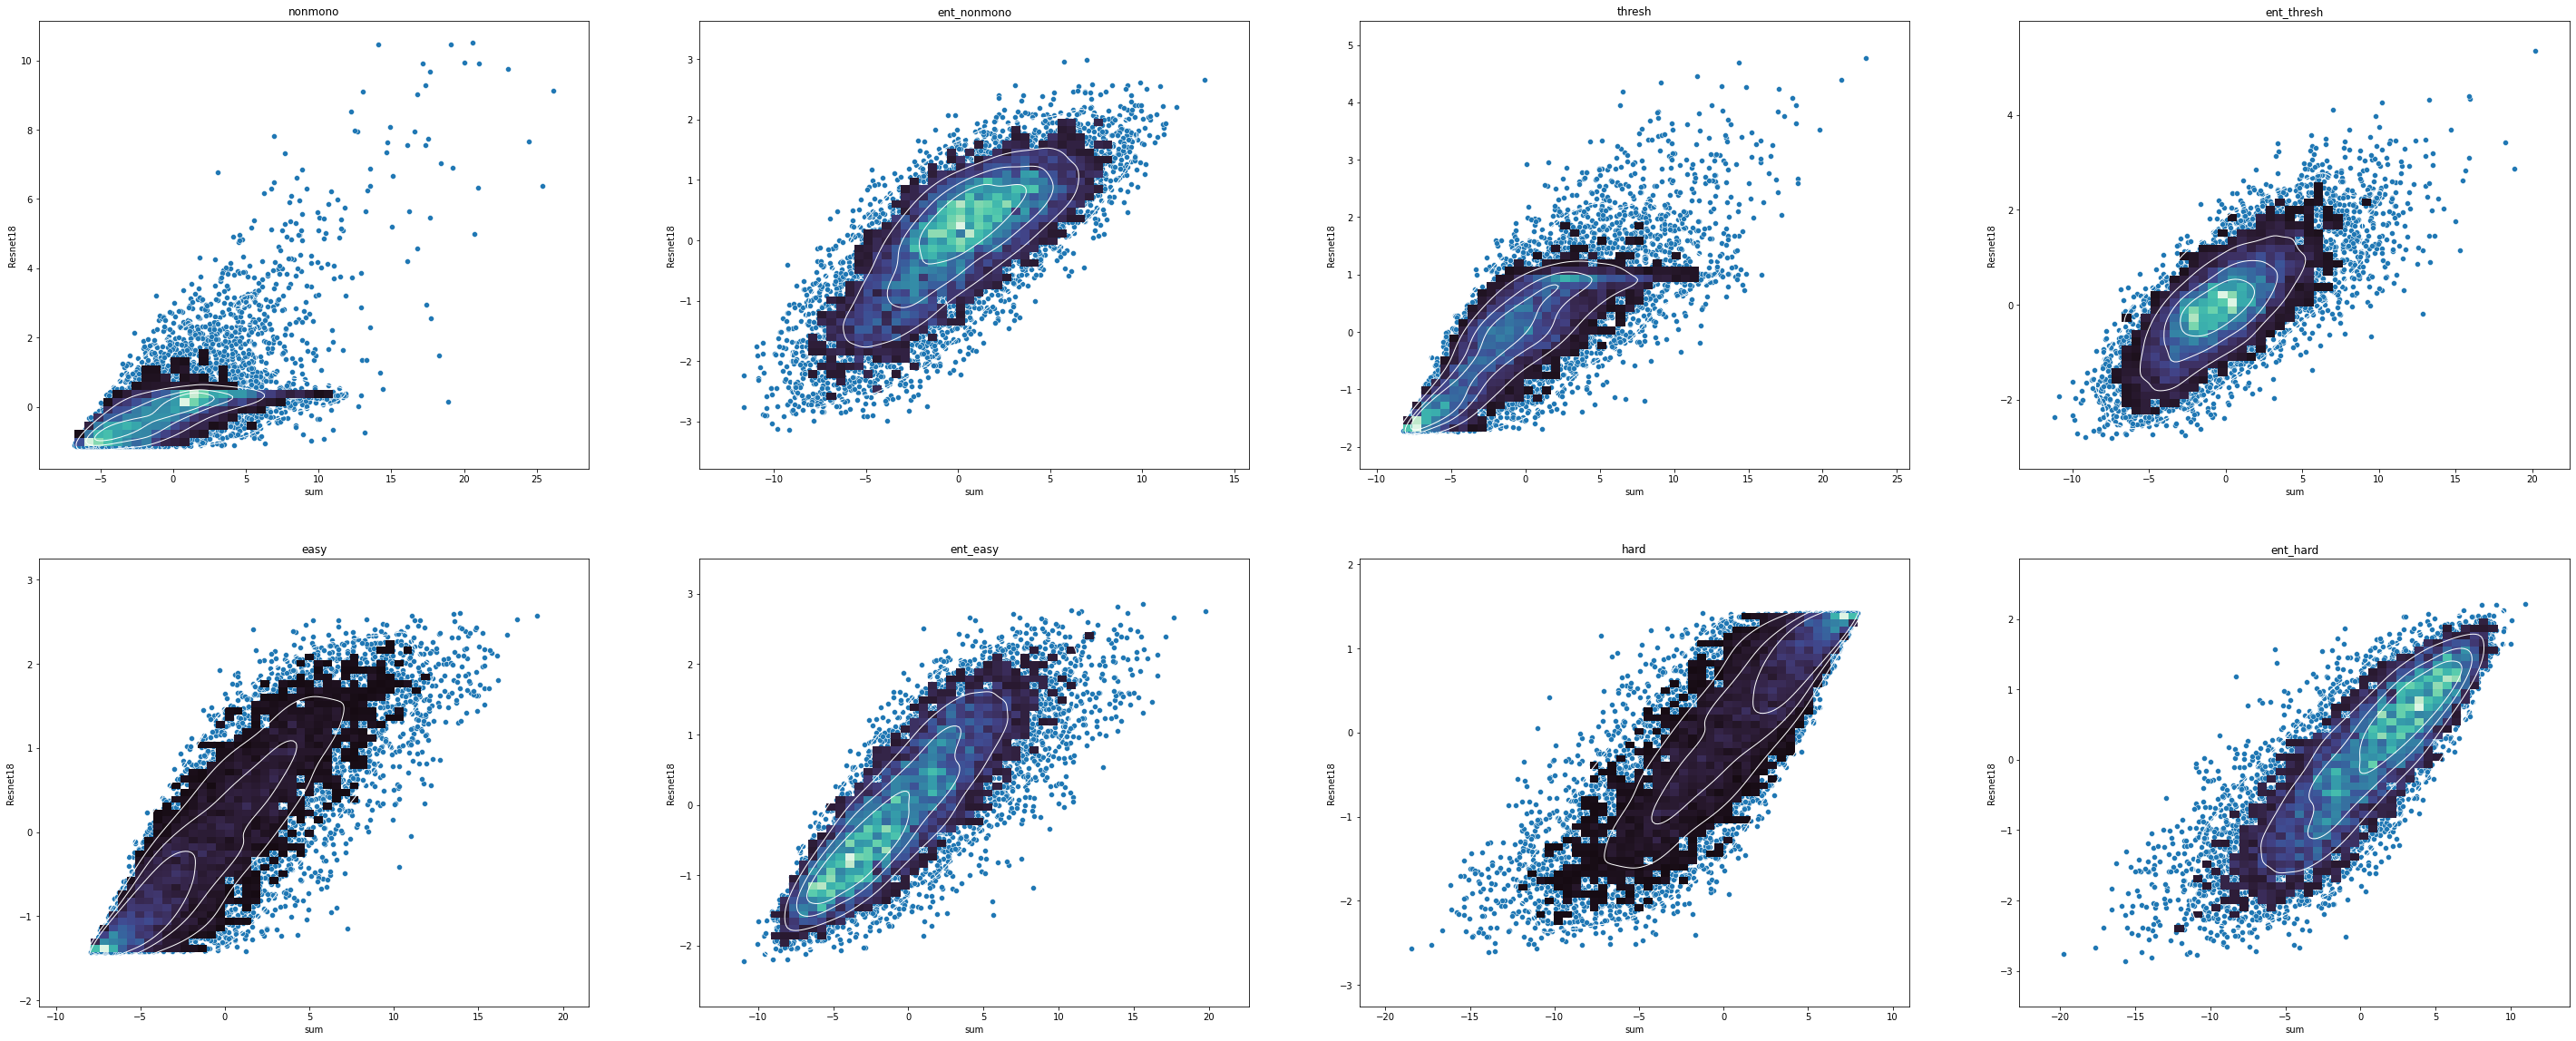

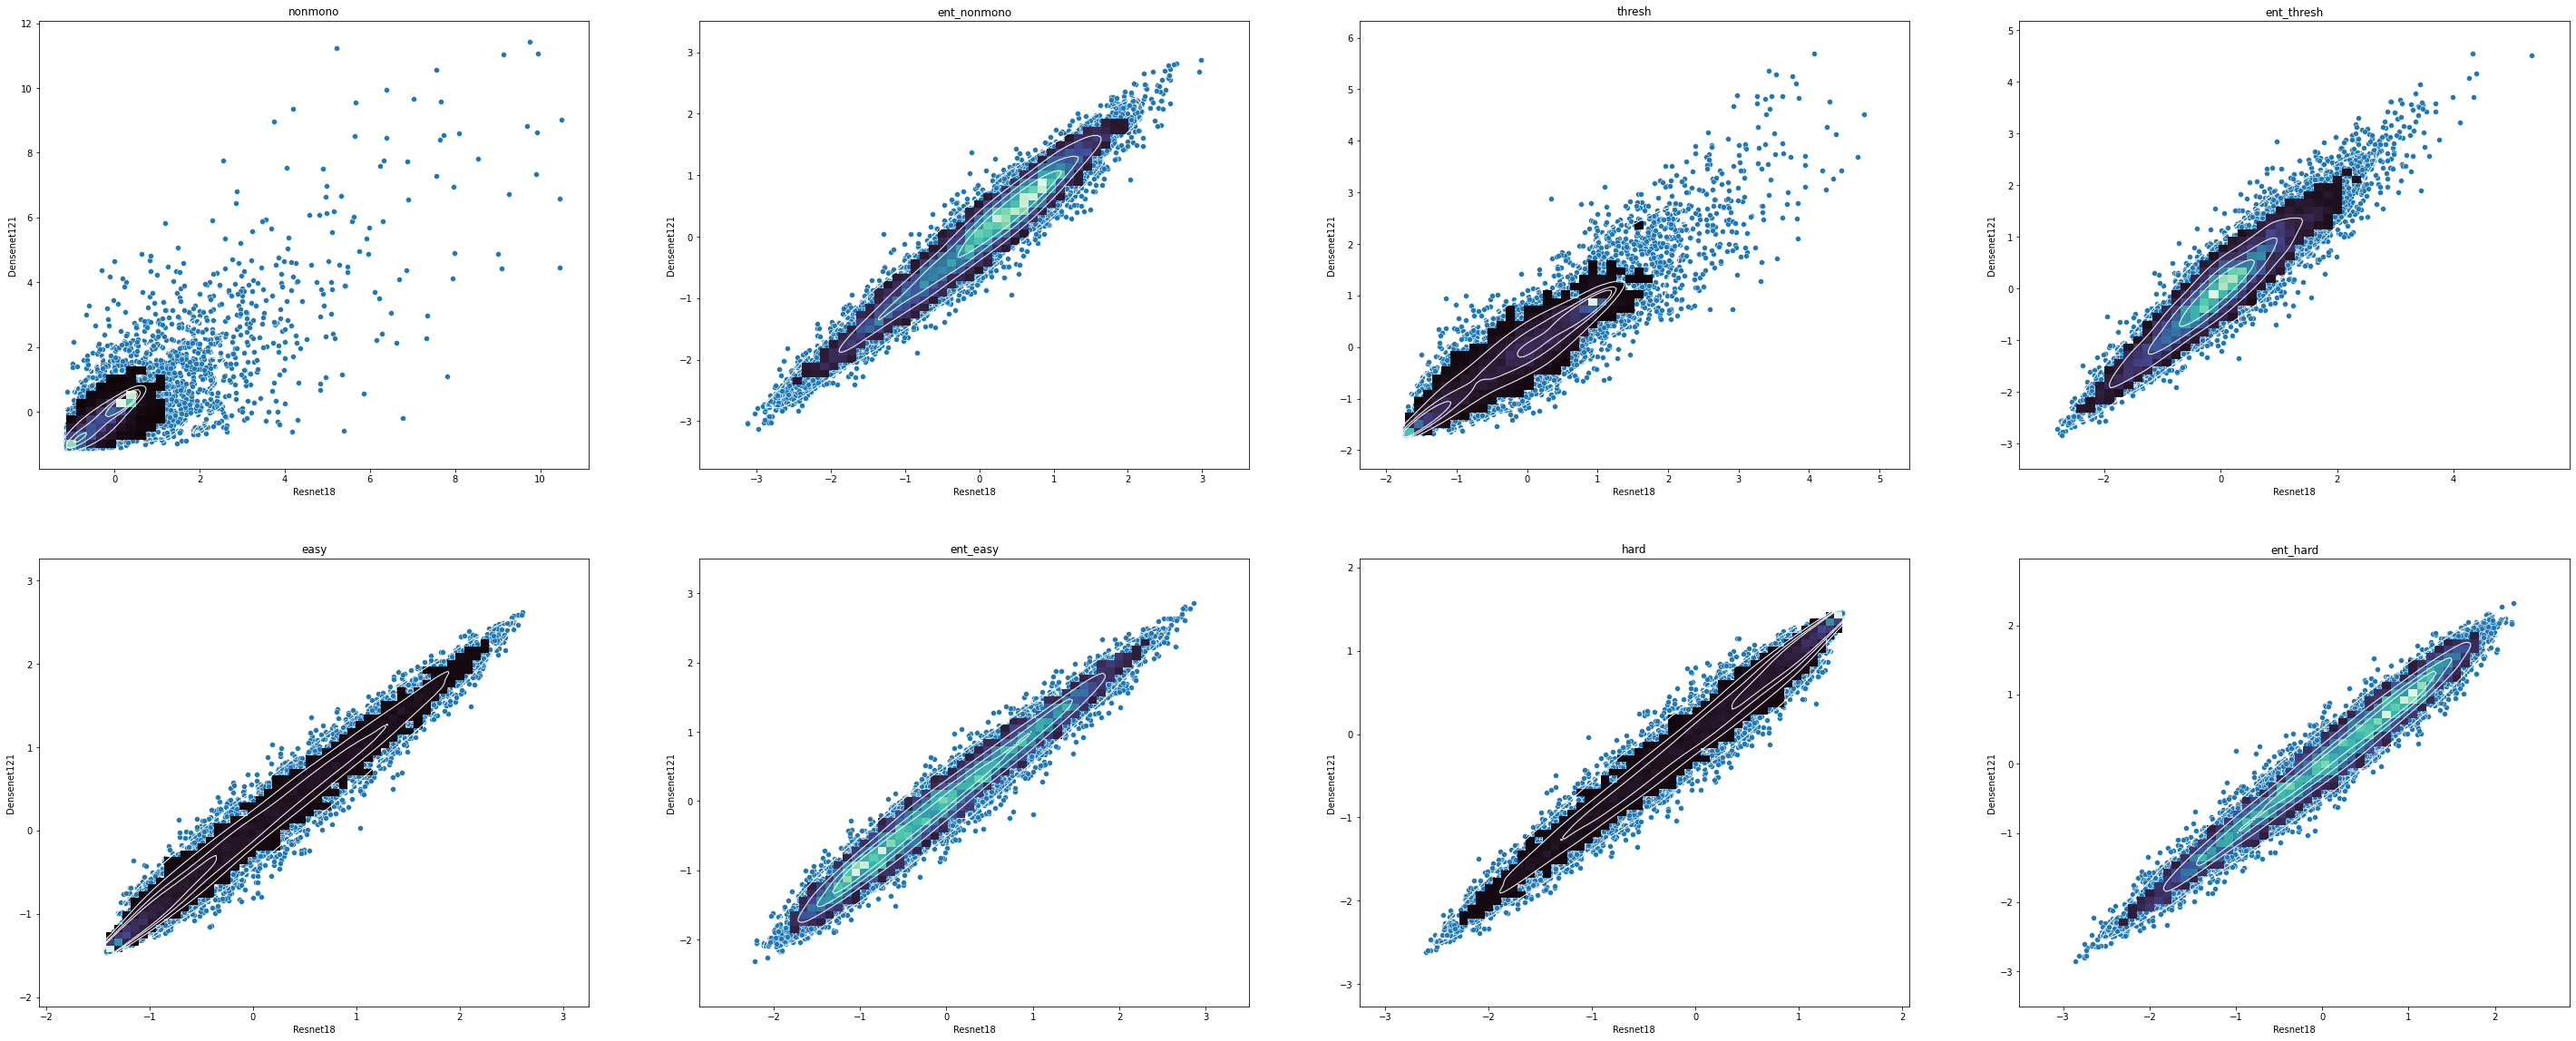

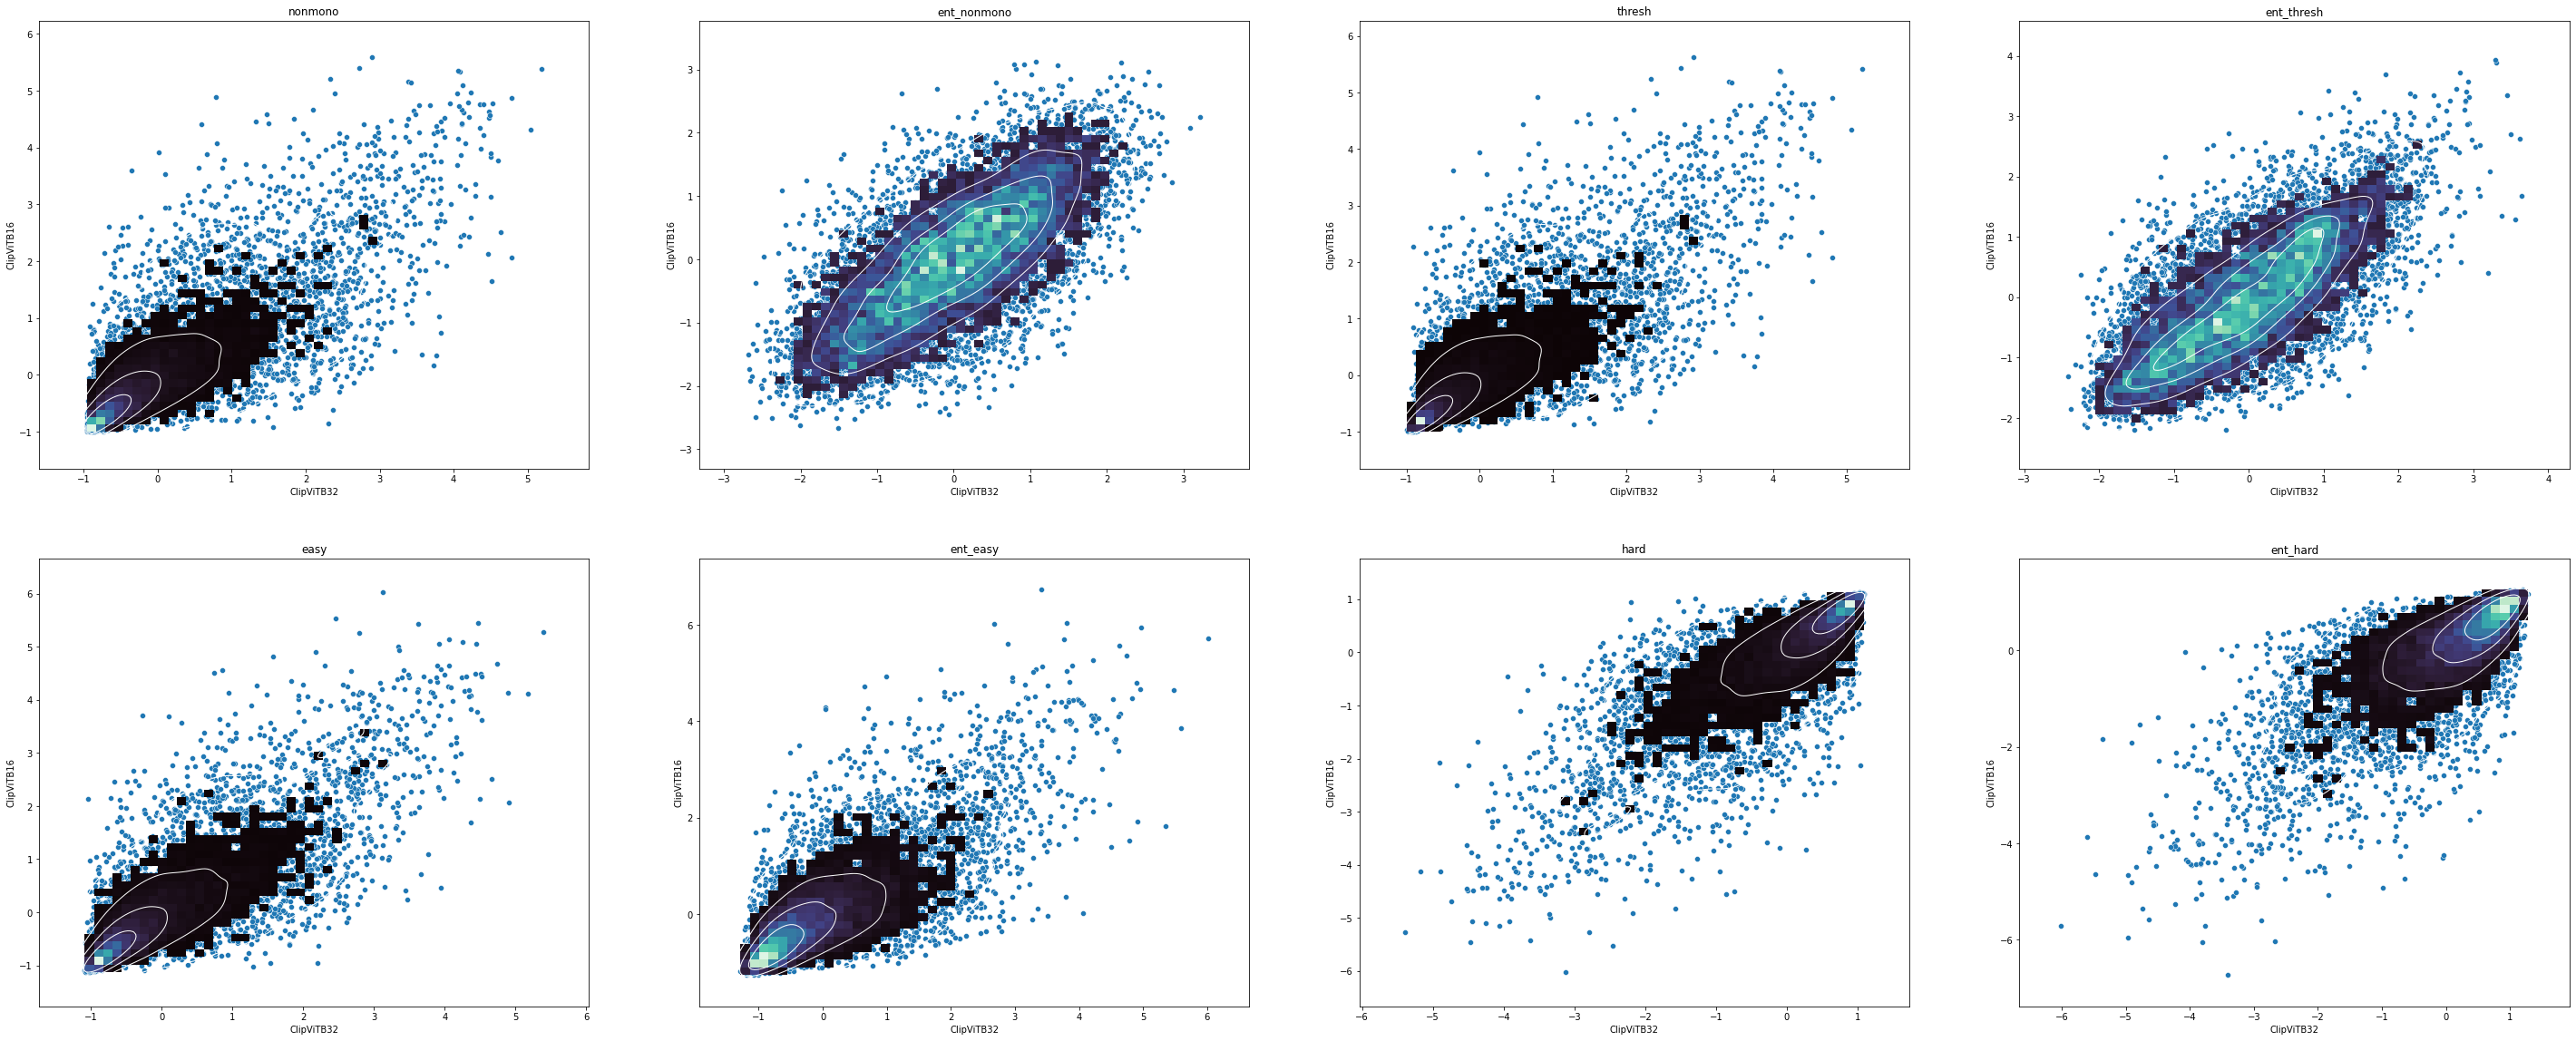

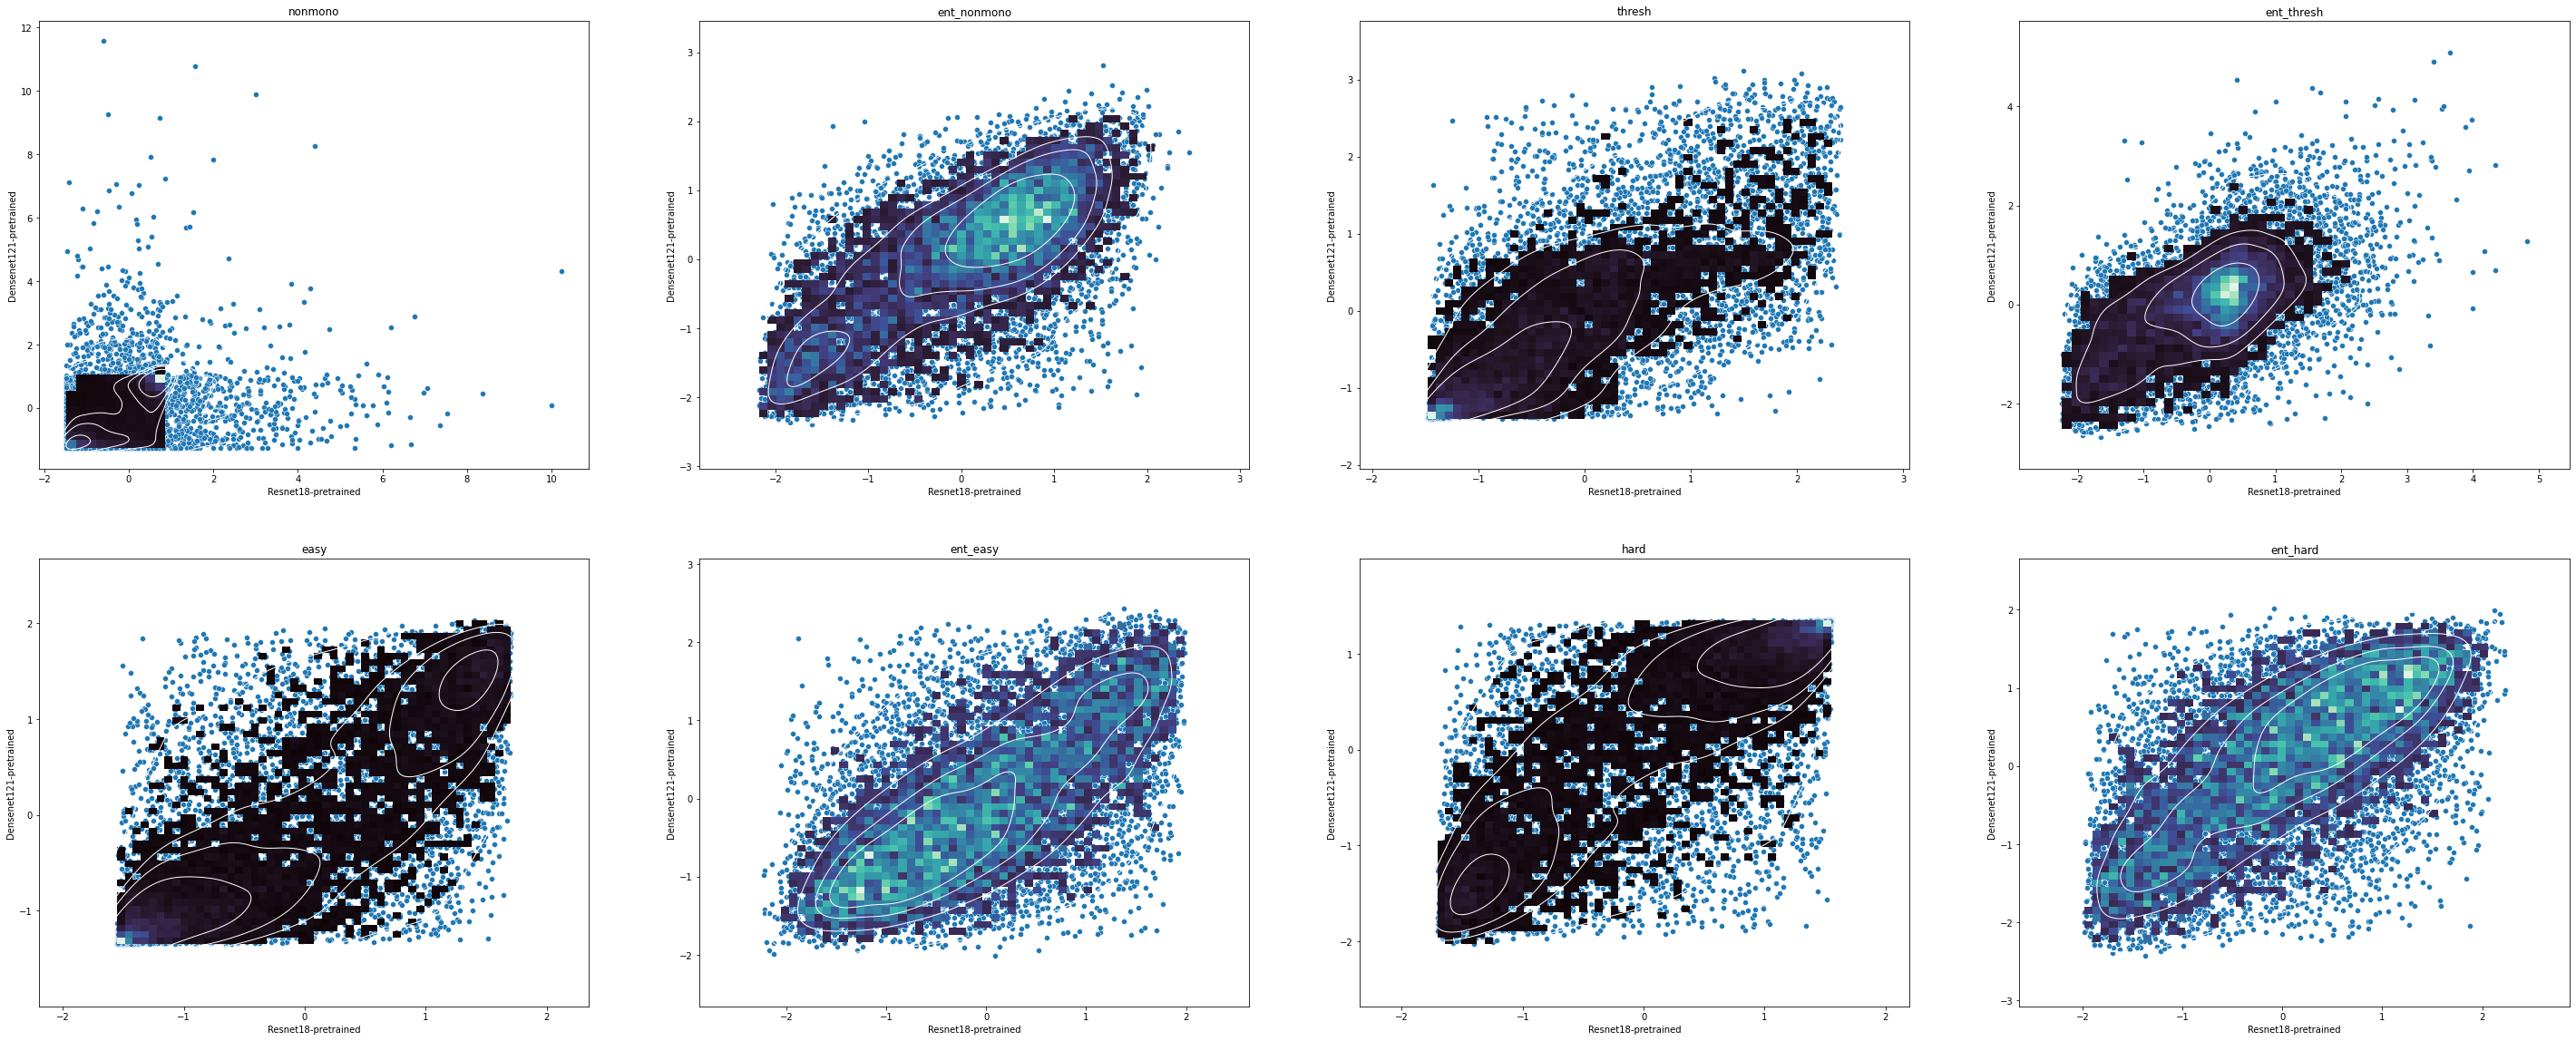

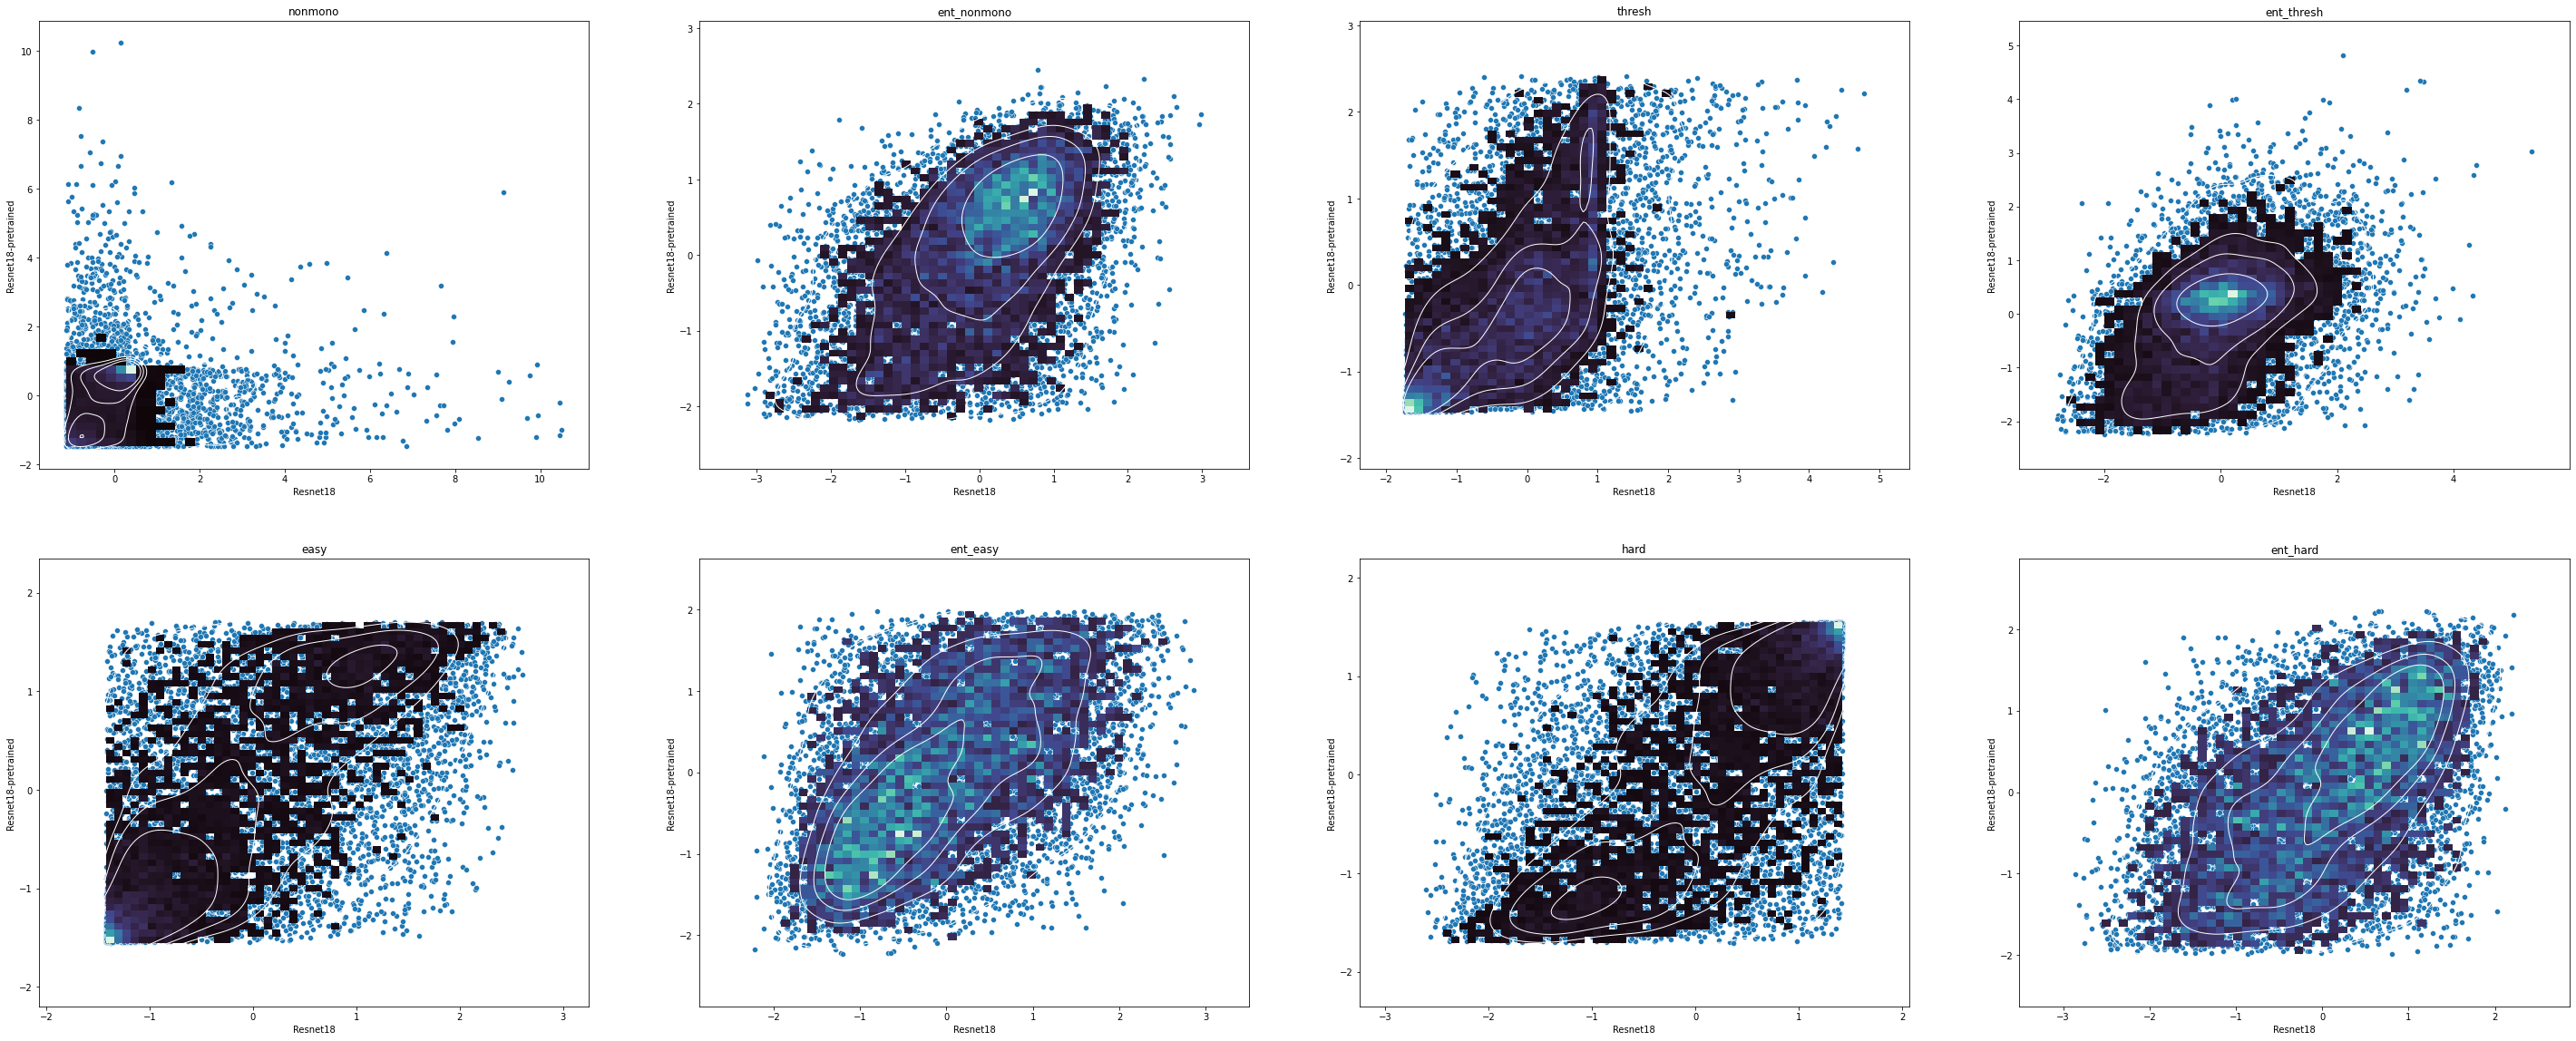

In [32]:
pairs = [ ('sum' , 'Resnet18'), ('Resnet18','Densenet121'), ('ClipViTB32', 'ClipViTB16'),('Resnet18-pretrained', 'Densenet121-pretrained'), ('Resnet18','Resnet18-pretrained') ]


for x_,y_ in pairs:
    ncols = int( (len(NAMES)+1)/2)
    f, axs = plt.subplots(ncols = ncols, nrows=2, figsize = (50, 20))
    for i,metric in enumerate(NAMES):
        x = scores[x_][metric]
        y  = scores[y_][metric]
        c = i % ncols
        r = i // ncols
        ax = axs[r][c]
        sns.scatterplot(ax=ax,x= x,y=y).set(title=metric, xlabel=x_,ylabel=y_)
        sns.histplot(ax=ax,x=x, y=y, bins=50, pthresh=.1, cmap="mako")
        sns.kdeplot(ax=ax, x=x, y=y, levels=5, color="w", linewidths=1)
    plt.show()

In [ ]:
scores_ = dict(scores)
del scores_['nonmono']
df =  pd.DataFrame(scores_)
sns.displot(df)

In [ ]:
idxes = {} 
for k,s in scores.items():
    print(k)
    idxes[k] = np.argsort(-s)

# INDICES = np.flatnonzero(scores > 0.02)
# scores = scores[INDICES]
# sns.displot(scores)

In [ ]:
scores['hard'][idxes['hard'][0]]

In [ ]:
def stacksimple(i, x, prof, topk=5, ax=None):
    """
        i: index of image in dataset
        x: x-axis points
        prof: profile (NUM_LABELS, len(x))
        topk: number of "main" labels, for the legend.
    """
    true_label = ytest[i]
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals

    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        # f, ax = plt.subplots(figsize=(7, 5))
        f, ax = plt.subplots(figsize=(3, 2))
    
    colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    cm = sns.color_palette('rainbow', as_cmap=True)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.3))
        s.set_linewidth(0.2)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' '), labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    ax.set_axis_off()  
    sns.despine()
    
    ax2 = ax.inset_axes([1.01, 0.7, 0.3, 0.3], aspect='equal')
    ax2.set_axis_off()
    ax2.imshow(dataset[i][0])
    
    return ax.figure


## generate plot
xkey = 'x' if t!='probs' else 'xsoft'
xkey = 'x'
x = G[xkey]
# i = rng.choice(INDICES) # random image index
i=idxes['nonmono'][0]
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'

yy = G[t][i]
for j in range(len(yy)):
    yy[j] = gaussian_filter1d(yy[j], sigma=1.0)
    
f = stacksimple(i, x, yy) # the actual plot
f.axes[0].set_title(f'{gname}: {t}. Sample {i}');
f

In [ ]:
import random
models = ['ClipViTB32','Resnet18', 'Densenet121', 'Resnet18-pretrained', 'Densenet121-pretrained', 'ClipViTB16']
t = 'probs'
TOP = 100
ncols = len(scores.keys())
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'
f, axs = plt.subplots(nrows=len(models), ncols=ncols, figsize = (50, 20))
for c,k in enumerate(scores.keys()):
    rank = random.randrange(TOP)
    i=idxes[k][rank] # image index
    score = scores[k][i]
    for r in range(len(models)): # each row is a model
        ax = axs[r][c]
        
        m = models[r]
        G = Gs[m]
        xkey = 'x' # if t!='probs' else 'xsoft'
        x = G[xkey]

        yy = G[t][i]
        for j in range(len(yy)):
            yy[j] = gaussian_filter1d(yy[j], sigma=1.0)
        
        stacksimple(i, x, yy, ax=ax) # the actual plot
        title = ''
        if r==0:
            title = f"{k} {i} ({rank}th, score: {score:.2f}) "
        if c==0:
            title += f"{m}"
        ax.set_title(title);

plt.tight_layout()

In [ ]:
axs.shape